In [1]:
import sys
import matplotlib.pyplot as plt
from contextualbandits import online as cb
from copy import deepcopy as clone
import numpy as np
import pandas as pd
# The only classifiers that have partial_fit
# See: https://scikit-learn.org/0.15/modules/scaling_strategies.html
from sklearn.linear_model import SGDClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
sys.path.append("../src")

%matplotlib inline

In [2]:
from wrappers import decision_function_from_proba

In [3]:
df = pd.read_csv("../data/data.csv")

df = df.sample(frac=0.02)

# Read data & preprocess

In [4]:
def keep_values_by_min_freq(df, col, freq=0.9,other="OTHER"):
    ds = df[col].value_counts(normalize=True).cumsum()
    mapped2other = []
    marked_as_other = False
    for val, prop in ds.iteritems():
        if marked_as_other:
            mapped2other.append(val)
        if prop>freq:
            marked_as_other=True
    df.loc[df[col].isin(mapped2other), col]=other
    df[col] = df[col].astype('category')
    
    return df

In [5]:
def preprocess(df):
    # preprocess
    df = df.drop("sessionId", axis=1)
    df["eventTimestamp"] = pd.to_datetime(df["eventTimestamp"]*1_000_000)
    df["day_of_week"]=df["eventTimestamp"].dt.weekday.astype("category")
    df["time_of_day"]=df["eventTimestamp"].dt.hour.astype("category")
    df.sort_values(by='eventTimestamp', inplace=True)    
    df = df.drop("eventTimestamp", axis=1)
    for col, dtype in df.dtypes.iteritems():
        if str(dtype) == 'object':
            df = keep_values_by_min_freq(df, col)
    
    df = keep_values_by_min_freq(df, 'adNetworkId')
    df = keep_values_by_min_freq(df, 'userTrackingAuth')
    
    # a, r, X for models
    a = df["bidPrice"].round(2)
    r = df["hasWon"]
    df = df.drop(["bidPrice", "hasWon", "bundleId", "advertisedBundle"] ,axis=1)
    X = pd.get_dummies(df)
    
    return X, a, r

def preprocess_only_one_feature(df):
    # preprocess
    df = df[['bidPrice', 'placementType', 'hasWon']]
    
    # a, r, X for models
    a = df["bidPrice"].round(0)
    r = df["hasWon"]
    df = df.drop(["bidPrice", "hasWon"] ,axis=1)
    X = pd.get_dummies(df)
    
    return X, a, r


# sample
### Note for arms - we should know in advance, per each context, what is the maximum bid
# e.g. for iOS, size=320x50, plc=Banner, we should know that 10 is the maximum and not create an arm for X>10...
# Maybe - it should be calculated every X days (1 day...)

# df = df.query("placementType=='banner' and bidPrice<1.01").drop("placementType",axis=1)
df.drop("placementType", axis=1)

# X, a, r = preprocess(df)
X, a, r = preprocess_only_one_feature(df)
X.columns

Index(['placementType_banner', 'placementType_interstitial',
       'placementType_rewarded'],
      dtype='object')

# Contextual bandits

In [9]:
bids = sorted(set(a))
n_arms = len(bids)
base_model = SGDClassifier(loss='log')

desired_win_rate=0.1
@decision_function_from_proba(base_model)
def normalize_proba(proba):
    return 1/np.abs(proba-desired_win_rate + 0.0001)

# logreg_ts = cb.BootstrappedTS(clone(base_model), n_arms, batch_train=True)
# logreg_ucb = cb.BootstrappedUCB(clone(base_model), n_arms, batch_train=True)
# logreg_eg = cb.EpsilonGreedy(clone(base_model), n_arms, batch_train=True)

logreg_sg = cb.SeparateClassifiers(clone(base_model), n_arms, batch_train=True)

In [10]:
def simulate(model, X, a , r, chunk = 100, limit=100):
    X,a,r=map(clone,[X,a,r]) # copy the existing data so we won't change it
    
    train_X, train_a, train_r = X.iloc[:chunk,:], a[:chunk], r[:chunk] 
    # split the data into train
    # Get chunk data points for first input
    X, a, r = X.iloc[chunk:,:], a[chunk:], r[chunk:]
    test_X, test_a, test_r = X.iloc[:chunk,:], a[:chunk], r[:chunk]
    n_iterations = 1
    regrets = []
    
    while len(X)>chunk:
        model.partial_fit(train_X,train_a,train_r)
        pred_bids = model.predict(test_X)
        regrets.append(np.sum([np.abs(bids[i]-y) for i,y in zip(pred_bids,test_r.values)])/chunk)
        train_X, train_a, train_r    = X.iloc[:chunk,:], a[:chunk], r[:chunk]
        X, a, r = X.iloc[chunk:,:], a[chunk:], r[chunk:]
        test_X, test_a, test_r = X.iloc[:chunk,:], a[:chunk], r[:chunk]
        n_iterations+=1
        if limit>0 and limit<n_iterations:
            break
            
    return regrets

# plot

Text(0.5, 0, 'iterations')

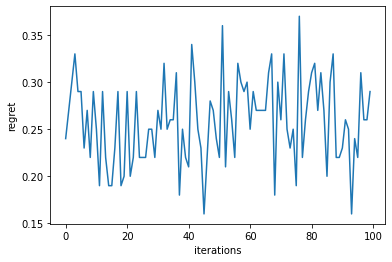

In [12]:
regret = simulate(logreg_sg, X, a, r)
plt.plot(np.arange(len(regret)), regret)
plt.ylabel("regret")
plt.xlabel("iterations")

In [ ]:
logreg_sg.base

In [14]:
# regret = simulate(logreg_ts, X,a,r)
# plt.plot(np.arange(len(regret)), regret)
# regret = simulate(logreg_ucb, X,a,r)
# plt.plot(np.arange(len(regret)), regret)
# regret = simulate(logreg_eg, X,a,r)
# plt.plot(np.arange(len(regret)), regret)
# plt.ylabel("regret")
# plt.xlabel("iterations")



# Directions for next meeting:
# 1. Uri will investigate the behavior on small data + base "dummy" model
# 2. Temporal Bagging - interesting to try, Uri and Daniel next meeting
